# Lecture 31: Least Squares

In [1]:
from datascience import *
import numpy as np

import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
%matplotlib inline

## Linear regression

In [2]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers)) / np.std(any_numbers)  

def correlation(t, x, y):
    """Return the correlation coefficient (r) of two variables."""
    return np.mean(standard_units(t.column(x)) * standard_units(t.column(y)))

def slope(t, x, y):
    """The slope of the regression line (original units)."""
    r = correlation(t, x, y)
    return r * np.std(t.column(y)) / np.std(t.column(x))

def intercept(t, x, y):
    """The intercept of the regression line (original units)."""
    return np.mean(t.column(y)) - slope(t, x, y) * np.mean(t.column(x))

In [3]:
# From an actual class, but anonymized
exams = Table().read_table('exams.csv')
exams.show(3)

prelim,final
98,97
97,89
97,91


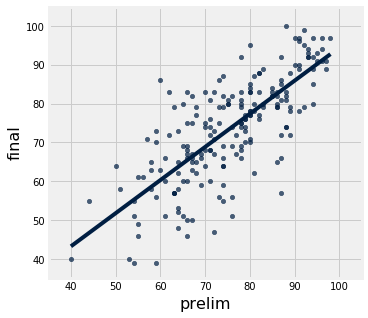

In [4]:
# Does linear regression look appropriate?
exams.scatter('prelim', fit_line=True)
plots.xlim(35, 105);
plots.ylim(35, 105);

In [5]:
r = correlation(exams, 'prelim', 'final')
s = slope(exams, 'prelim', 'final')
i = intercept(exams, 'prelim', 'final')
print('Correlation: ', r)
print('Slope:       ', s)
print('Intercept:   ', i)

Correlation:  0.7560369689141728
Slope:        0.8534287418008346
Intercept:    9.099487179487184


**Q:** Which equation would you use to predict a final exam score $y$ given a prelim score $x$, both in original units (percent)?

A. $y = r \times x$  
B. $y = r \times x + i$  
C. $y = s \times x + i$  
D. none of the above


In [6]:
def predict_final(prelim):
    return s * prelim + i

In [7]:
predict_final(100) # regression to the mean?

94.44236135957064

In [8]:
predict_final(30)

34.702349433512225

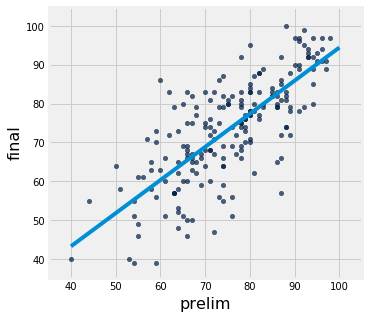

In [9]:
exams.scatter('prelim')
plots.xlim(35, 105);
plots.ylim(35, 105);

# plot the regression line
x = make_array(40, 100)
y = s * x + i
plots.plot(x, y);

## Abuses of $r$

**1. Summarizing non-linear data**

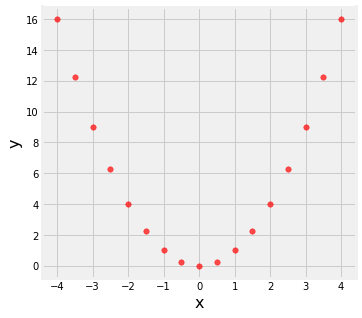

In [10]:
new_x = np.arange(-4, 4.1, 0.5)
nonlinear = Table().with_columns(
        'x', new_x,
        'y', new_x**2
    )
nonlinear.scatter('x', 'y', s=30, color='r')

In [11]:
correlation(nonlinear, 'x', 'y')

0.0

There is definitely a relationship between $x$ and $y$.  It's just not linear.

**2. Eliminating outliers to "improve" $r$**

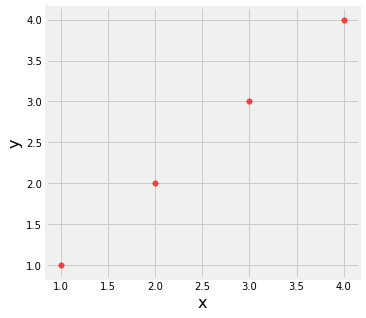

In [12]:
line = Table().with_columns(
        'x', [1, 2, 3, 4],
        'y', [1, 2, 3, 4]
    )
line.scatter('x', 'y', s=30, color='r')

In [13]:
correlation(line, 'x', 'y')

1.0

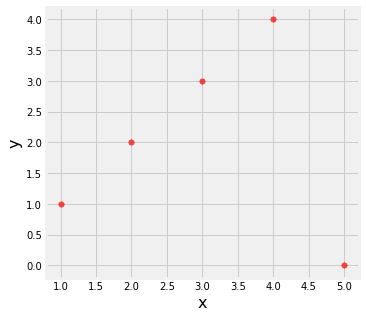

In [14]:
outlier = Table().with_columns(
        'x', [1, 2, 3, 4, 5],
        'y', [1, 2, 3, 4, 0]
    )
outlier.scatter('x', 'y', s=30, color='r')

In [15]:
correlation(outlier, 'x', 'y')

0.0

Because weight that outlier contributes to product is huge and offsets the linearity of the rest of the data.  **Do not rush to eliminate outliers from data.**  Maybe that data point is a measurement error, but maybe it indicates underlying population is non-linear.

**3. Drawing conclusions about individuals based on data about groups**

In [16]:
# Participation rate = % of high school seniors who took SAT
# Scores are average scores across state
sat2014 = Table.read_table('sat2014.csv')
sat2014.sort('Combined', descending=True)

State,Participation Rate,Critical Reading,Math,Writing,Combined
North Dakota,2.3,612,620,584,1816
Illinois,4.6,599,616,587,1802
Iowa,3.1,605,611,578,1794
South Dakota,2.9,604,609,579,1792
Minnesota,5.9,598,610,578,1786
Michigan,3.8,593,610,581,1784
Wisconsin,3.9,596,608,578,1782
Missouri,4.2,595,597,579,1771
Wyoming,3.3,590,599,573,1762
Kansas,5.3,591,596,566,1753


-0.9111376507316862

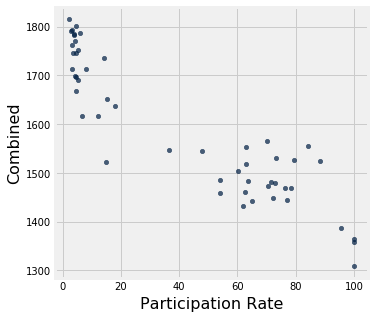

In [17]:
sat2014.scatter('Participation Rate', 'Combined')
correlation(sat2014, 'Participation Rate', 'Combined')

**Q:** States with higher participation rates have lower average scores.  Why?

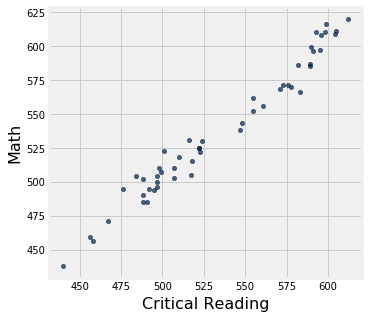

In [18]:
sat2014.scatter('Critical Reading', 'Math')

In [19]:
correlation(sat2014, 'Critical Reading', 'Math')

0.9847558411067433

**Q:** Do students with high reading scores also have high math scores?

A. Yes  
B. No  
C. Maybe


## Quantifying error

In [20]:
def read_file(f):
    with open (f, 'r') as file:
        data=file.read()
    return data
lw_text = read_file('little_women.txt')
lw_chapters = lw_text.split('CHAPTER ')[1:]
lw = Table().with_columns(
    'Periods', np.char.count(lw_chapters, '.'),
    'Characters', np.vectorize(len)(lw_chapters),
)

lw.show(3)

Periods,Characters
189,21952
188,22384
231,20815


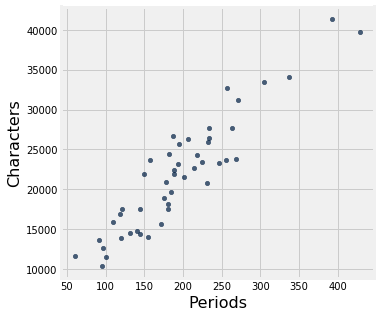

In [21]:
lw.scatter('Periods', 'Characters')

In [22]:
correlation(lw, 'Periods', 'Characters')

0.9249624873296186

In [23]:
def linear_predict(t, x, y):
    """Return the height of the regression line at each x value."""
    s = slope(t, x, y)
    i = intercept(t, x, y)
    return s * t.column(x) + i

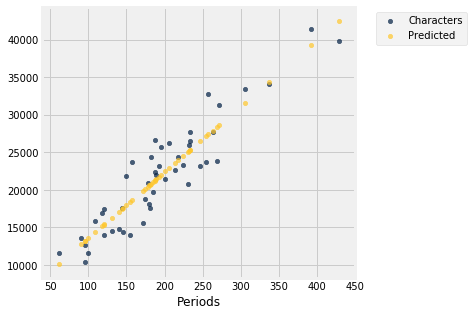

In [24]:
lw_predicted = lw.with_column(
    'Predicted', linear_predict(lw, 'Periods', 'Characters')
)
lw_predicted.scatter('Periods')

In [25]:
sample = [[131, 14431], [231, 20558], [392, 40935], [157, 23524]]
def lw_errors(slope, intercept):
    print('Slope:    ', np.round(slope), 'characters per period')
    print('Intercept:', np.round(intercept), 'characters')
    lw.scatter('Periods', 'Characters')
    xlims = np.array([50, 450])
    plots.plot(xlims, slope * xlims + intercept, lw=2)
    for x, y in sample:
        plots.plot([x, x], [y, slope * x + intercept], color='r', lw=2)

Slope:     88.0 characters per period
Intercept: 4802.0 characters


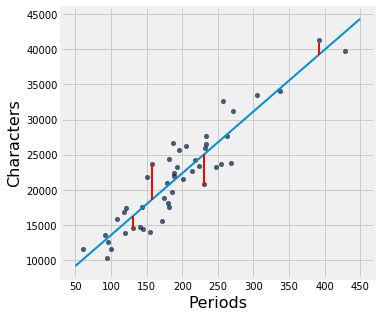

In [26]:
lw_reg_slope = slope(lw, 'Periods', 'Characters')
lw_reg_intercept = intercept(lw, 'Periods', 'Characters')
lw_errors(lw_reg_slope, lw_reg_intercept)

In [27]:
error = lw_predicted.column('Characters') - lw_predicted.column('Predicted')
lw_predicted_error = lw_predicted.with_column(
    'Error', error
)
lw_predicted_error.show(3)

Periods,Characters,Predicted,Error
189,21952,21403.2,548.823
188,22384,21315.3,1068.66
231,20815,25092.4,-4277.36


**Q:** What would be a good way to summarize all those errors as a single number?

## RMSE

In [28]:
lw_predicted_error_sq = lw_predicted_error.with_column(
    'Squared Error', error ** 2
)
lw_predicted_error_sq.show(3)

Periods,Characters,Predicted,Error,Squared Error
189,21952,21403.2,548.823,301207
188,22384,21315.3,1068.66,1.14204e+06
231,20815,25092.4,-4277.36,1.82958e+07


In [29]:
mean_squared_error = np.mean(lw_predicted_error_sq.column('Squared Error'))
mean_squared_error

7226584.405390953

In [30]:
root_mean_squared_error = np.sqrt(mean_squared_error)
root_mean_squared_error

2688.2307202676916

rmse = SD($y$) $\times \sqrt{1 - r^2}$

In [31]:
np.sqrt(1 - correlation(lw, 'Periods', 'Characters')**2) * np.std(lw.column('Characters'))

2688.2307202676907

## Comparing lines with RMSE

In [32]:
def lw_visualize_rmse(slope, intercept):
    lw_errors(slope, intercept)
    x = lw.column('Periods')
    y = lw.column('Characters')
    predicted = slope * x + intercept
    mse = np.mean((y - predicted) ** 2)
    print("RMSE:     ", mse ** 0.5)

Slope:     50 characters per period
Intercept: 10000 characters
RMSE:      4459.936258012206


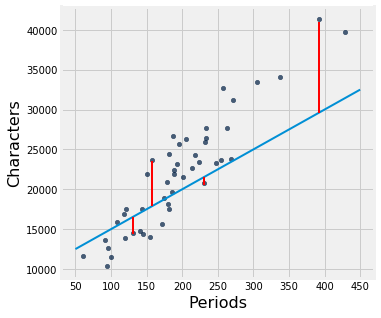

In [33]:
lw_visualize_rmse(50, 10000)

**Q:** Which way should I adjust slope to reduce error?

A. Up  
B. Down  
C. I'm not sure  

Slope:     88.0 characters per period
Intercept: 4802.0 characters
RMSE:      2688.2307202676916


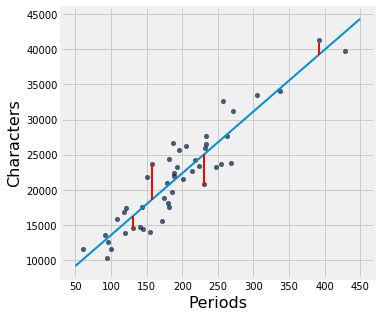

In [34]:
lw_reg_slope = slope(lw, 'Periods', 'Characters')
lw_reg_intercept = intercept(lw, 'Periods', 'Characters')
lw_visualize_rmse(lw_reg_slope, lw_reg_intercept)

## Finding the line with least RMSE

In [35]:
def f(x):
    return (x - 3) ** 2 + 1

**Q:** What value of `x` will produce the smallest value of `f(x)`?

A. 0  
B. 1  
C. 2  
D. 3  
E. none of the above

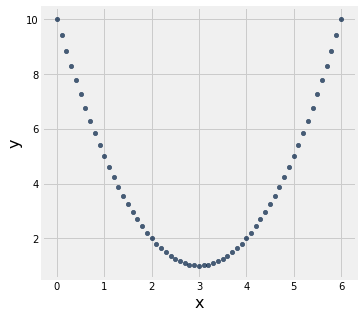

In [36]:
x = np.arange(0, 6.1, .1)
y = f(x)
Table().with_columns('x', x, 'y', y).scatter('x')

In [37]:
minimize(f)

2.999999999968361

In [38]:
f(minimize(f))

1.0

In [39]:
def lw_rmse(any_slope, any_intercept):
    """Compute the RMSE for a line through the Little Women data.
    The line has the slope and intercept given as arguments."""
    x = lw.column('Periods')
    y = lw.column('Characters')
    predicted = any_slope*x + any_intercept
    return np.sqrt(np.mean((y - predicted) ** 2))

In [40]:
lw_rmse(50, 10000)

4459.936258012206

In [41]:
best = minimize(lw_rmse)
best

array([  87.83771175, 4801.84916341])

In [42]:
lw_rmse(best.item(0), best.item(1))

2688.2307202676916

In [43]:
make_array(lw_reg_slope, lw_reg_intercept)

array([  87.83771175, 4801.84917407])

In [44]:
lw_rmse(lw_reg_slope, lw_reg_intercept)

2688.2307202676916